In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from transformers import BertModel
from transformers import BertTokenizer
import os, sys, time
from sklearn import preprocessing
from scipy import stats
from collections import defaultdict
import numpy as np
import pandas as pd
import statistics
import transformers
from ipywidgets import FloatProgress
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import copy
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from collections import OrderedDict
from PIL import Image
#plt.ion()   # interactive mode
from random import shuffle


In [2]:
data_folder=os.getcwd()
test_set="book30-listing-test.csv"
train_set="book30-listing-train.csv"

test=pd.read_csv(os.path.join(data_folder+"/"+test_set), sep=",", encoding='latin_1')
train=pd.read_csv(os.path.join(data_folder+"/"+train_set), sep=",", encoding='latin_1')
#setting up columns' names
test=test.set_axis(["AMAZON INDEX (ASIN)","FILENAME","IMAGE URL","TITLE","AUTHOR","CATEGORY ID","CATEGORY"], axis=1, inplace=False)
train=train.set_axis(["AMAZON INDEX (ASIN)","FILENAME","IMAGE URL","TITLE","AUTHOR","CATEGORY ID","CATEGORY"], axis=1, inplace=False)

#selecting title and category id
test_set = test[['FILENAME','TITLE','CATEGORY ID', "CATEGORY", "IMAGE URL"]]
train_set = train[['FILENAME','TITLE','CATEGORY ID', "CATEGORY", "IMAGE URL"]]


In [3]:
length = len(train_set) + len(test_set)
print(0.8*length, 0.1* length, 0.1*length)

train_set = train_set.sample(frac=1).reset_index(drop=True) #shuffling for val data set
#print(train_set)
#print(train_set2.head())

train_s=train_set[:45598] 
val_s=train_set[45598:] 

print(f'LENGTH OF VALIDATION SET: {len(val_s)}, \
      LENGTH OF TEST SET: {len(test_set)},  \
      LENGTH OF TRAIN SET: {len(train_s)}. ')


45598.4 5699.8 5699.8
LENGTH OF VALIDATION SET: 5701,       LENGTH OF TEST SET: 5699,        LENGTH OF TRAIN SET: 45598. 


Test set: \n Test Preparation                190
Biographies & Memoirs           190
Mystery, Thriller & Suspense    190
Science Fiction & Fantasy       190
Romance                         190
Teen & Young Adult              190
Comics & Graphic Novels         190
History                         190
Calendars                       190
Reference                       190
Humor & Entertainment           190
Travel                          190
Crafts, Hobbies & Home          190
Cookbooks, Food & Wine          190
Computers & Technology          190
Sports & Outdoors               190
Parenting & Relationships       190
Business & Money                190
Health, Fitness & Dieting       190
Politics & Social Sciences      190
Law                             190
Self-Help                       190
Children's Books                190
Christian Books & Bibles        190
Science & Math                  190
Engineering & Transportation    190
Literature & Fiction            190
Arts & Photogra

Text(0.5,0,'categories')

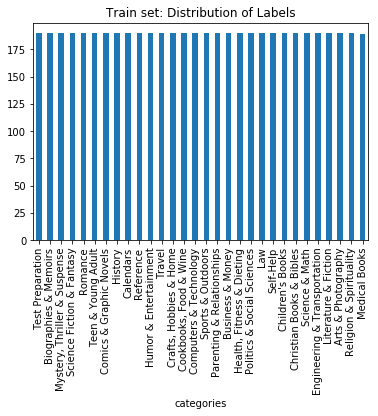

In [4]:
print('Test set:','\\n', test_set['CATEGORY'].value_counts())
test_set['CATEGORY'].value_counts().plot.bar()
plt.title('Train set: Distribution of Labels')
plt.xlabel('categories')

Val set: \n Science Fiction & Fantasy       215
Biographies & Memoirs           214
Religion & Spirituality         214
Law                             208
Computers & Technology          206
Test Preparation                203
Crafts, Hobbies & Home          203
Literature & Fiction            198
Romance                         197
Calendars                       196
Health, Fitness & Dieting       195
Travel                          195
Parenting & Relationships       195
Engineering & Transportation    191
Teen & Young Adult              190
Comics & Graphic Novels         190
Business & Money                187
Reference                       186
Mystery, Thriller & Suspense    186
Medical Books                   183
Science & Math                  183
Arts & Photography              179
Cookbooks, Food & Wine          178
Politics & Social Sciences      178
Children's Books                176
Self-Help                       175
Christian Books & Bibles        173
Humor & Entertai

Text(0.5,0,'categories')

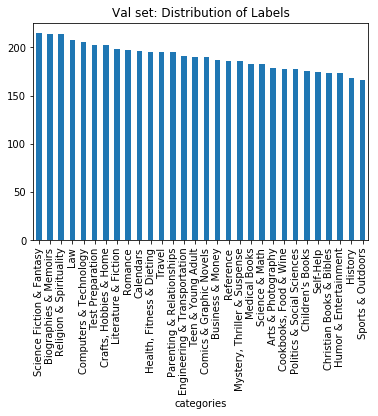

In [5]:
print('Val set:','\\n', val_s['CATEGORY'].value_counts())
val_s['CATEGORY'].value_counts().plot.bar()
plt.title('Val set: Distribution of Labels')
plt.xlabel('categories')

In [6]:
#creating dataset class for img and text
class Dataset(torch.utils.data.Dataset):

    def __init__(self, X, path, train = False):
        
        self.labels = [label for label in X['CATEGORY ID']]  
        self.texts = [tokenizer(title, truncation=True, padding='max_length', max_length = 74, 
                    return_tensors="pt") for title in X['TITLE']]
        self.images_name = [img_name for img_name in X['FILENAME']] 
        self.path = path
        self.label_name = [lbl_name for lbl_name in X['CATEGORY']]
        self.train = train
        self.path_img = [lbl_name for lbl_name in X['IMAGE URL']]
        
    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]
    
    def get_batch_label_name(self, idx):
        return self.label_name[idx]
            
    def get_batch_images_names(self, idx):
        # Fetch a batch of image names
        return self.images_name[idx]
    
    def get_img_path(self, idx):
        return self.path_img[idx]
    
    def get_batch_images(self, idx):
        # Fetch a batch of images
        batch_images_name = self.get_batch_images_names(idx)
        batch_label_name = self.get_batch_label_name(idx)
        img = Image.open(os.path.join(self.path, batch_label_name, batch_images_name)).convert('RGB')
        
        self.train = train
        
        if train:
            train_transform  =  transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
            img = train_transform(img)
        else:
            val_transform  =  transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
            img = val_transform(img)
                
        return img
        

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        batch_image = self.get_batch_images(idx)
        lb = self.get_batch_label_name(idx)
        img_p = self.get_img_path(idx)
        
        return batch_texts, batch_y, batch_image

In [7]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased',
                                         do_lower_case=True)

train, val = Dataset(train_s, "/home/gussikoju@GU.GU.SE/Data/sorted/train", True), Dataset(val_s, "/home/gussikoju@GU.GU.SE/Data/sorted/train")

In [20]:
#Loading data
train_all = Dataset(train_s, "/home/gussikoju@GU.GU.SE/Data/sorted/train", True)
val = Dataset(val_s, "/home/gussikoju@GU.GU.SE/Data/sorted/train")
test_all = Dataset(test_set, "/home/gussikoju@GU.GU.SE/Data/sorted/test")

### Loading pre-trained models

In [9]:
#loading saved text model

model_state_dict = torch.load('best_model.pth')
model_text = BertModel.from_pretrained( 'bert-base-cased', state_dict = model_state_dict, num_labels=30,  output_attentions = False, 
   output_hidden_states = False)

model_text = model_text.cuda()


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['linear.weight', 'linear.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
#Loading img model
model_img = models.resnet50(pretrained=True)
num_ftrs = model_img.fc.in_features
model_img.fc = nn.Linear(num_ftrs, 30)
model_img.load_state_dict(torch.load('CNN_model_april.pth'))

<All keys matched successfully>

In [11]:
#creating multimodal model

class MultimodalModel(nn.Module):
    def __init__(self, model_text, model_img):
        super(MultimodalModel, self).__init__()
        self.model_text = model_text
        self.model_img = model_img
        self.classifier = nn.Linear(30+30, 30)
        self.linear = nn.Linear(768, 30)
        
    def forward(self, img, text, text_mask):
        
        input_img = self.model_img(img)
        input_text = self.model_text(text, text_mask)
        input_text = input_text[1]
        input_text = self.linear(input_text)
        
        input_all = torch.cat((input_text, input_img), dim=1)
        input_all = self.classifier(nn.functional.relu(input_all))
        
        return input_all

my_model = MultimodalModel(model_text, model_img)

## Training the model

In [12]:
#Hyperparameters for training
my_model = my_model.cuda()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.SGD(my_model.parameters(), lr=0.001, momentum=0.9)
loss_fn = torch.nn.CrossEntropyLoss()

In [27]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    running_corrects = 0
    correct = 0
    total = 0
    training_loader = torch.utils.data.DataLoader(train_all, batch_size=10,shuffle=False) 
    
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, out in enumerate(training_loader):
        title, label, picture = out         
        mask = title['attention_mask']
        title = title['input_ids'][0]
        
        label = label.to(device)
        picture = picture.to(device)
        mask = mask.to(device)
        title = title.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()
        

        # Make predictions for this batch
        outputs = my_model(picture,title,mask)
        _, preds = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (preds == label).sum().item()

        # Compute the loss and its gradients
        loss = loss_fn(outputs, label)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        
        
        accuracy = 100 * correct / total
        
        if i % 10 == 9:
            last_loss = running_loss / 10 # loss per batch
            print('  batch {} loss: {} acc: {}%'.format(i + 1, last_loss, round(accuracy, 2)))
            running_loss = 0.
            
    return last_loss

In [22]:
# Initializing in a separate cell so we can easily add more epochs to the same run

epoch_number = 0 
validation_loader = torch.utils.data.DataLoader(val, batch_size=10,shuffle=False)

EPOCHS = 10


best_vloss = 1_000_000.


for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    #my_model.train(True)
    avg_loss = train_one_epoch(epoch_number)

    # We don't need gradients on to do reporting
    my_model.train(False)
    with torch.no_grad(): 
        my_model.eval()

        running_vloss = 0.0
        for i, vdata in enumerate(validation_loader):      
            vtitle, vlabel, vpicture = vdata   
            vmask = vtitle['attention_mask']
            vtitle = vtitle['input_ids'][0]

            vmask = vmask.to(device)
            vtitle = vtitle.to(device)
            vpicture = vpicture.to(device)
            vlabel = vlabel.to(device)

            voutputs = my_model(vpicture,vtitle,vmask)
            voutputs = voutputs.to(device)
            vloss = loss_fn(voutputs, vlabel)
            


            running_vloss += vloss

        avg_vloss = running_vloss / (i + 1)
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = 'model_{}_202'.format(epoch_number+1)
            torch.save(my_model.state_dict(), model_path)
    
    epoch_number += 1

EPOCH 1:
  batch 10 loss: 4.070899701118469 acc: 1.0%
  batch 20 loss: 3.8104970455169678 acc: 3.0%
  batch 30 loss: 3.5210182428359986 acc: 4.0%
  batch 40 loss: 3.4123648405075073 acc: 5.0%
  batch 50 loss: 3.3802656650543215 acc: 6.2%
  batch 60 loss: 3.4194091081619264 acc: 6.0%
  batch 70 loss: 3.196532130241394 acc: 6.57%
  batch 80 loss: 3.2573049783706667 acc: 7.25%
  batch 90 loss: 3.075413966178894 acc: 7.89%
  batch 100 loss: 3.1500975847244264 acc: 8.6%
  batch 110 loss: 3.0946518182754517 acc: 9.55%
  batch 120 loss: 3.2956631422042846 acc: 9.67%
  batch 130 loss: 3.07871732711792 acc: 10.15%
  batch 140 loss: 3.0758575677871702 acc: 10.71%
  batch 150 loss: 2.997204875946045 acc: 11.13%
  batch 160 loss: 3.056554579734802 acc: 11.12%
  batch 170 loss: 2.9494537830352785 acc: 11.59%
  batch 180 loss: 2.900449585914612 acc: 12.06%
  batch 190 loss: 2.8598143100738525 acc: 12.63%
  batch 200 loss: 3.1220588207244875 acc: 12.55%
  batch 210 loss: 2.882194972038269 acc: 12.81%

## Testing the model

In [15]:
def accuracyk(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-5 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(1.0 / batch_size))
        return res

In [22]:
# Function to test the model 
from sklearn.metrics import confusion_matrix
import seaborn as sn

def test_model(path_to_model): 
    # Load the model that we saved at the end of the training loop 
    y_pred = []
    y_true = []
    test_loader = torch.utils.data.DataLoader(test_all, batch_size=120,shuffle=False)

    model_new = MultimodalModel(model_text, model_img)
    path = path_to_model
    model_new.load_state_dict(torch.load(path)) 
    model_new = model_new.to(device)
    print('Model loaded.')
     
    running_accuracy = 0 
    total = 0 
    correct = 0
    total_top1 = []
    total_top3 = []
    total_top5 = []
 
    with torch.no_grad(): 
        for out in test_loader:
            title, label, picture = out         
            mask = title['attention_mask']
            title = title['input_ids'][0]
            
            label = label.to(device)
            picture = picture.to(device)
            mask = mask.to(device)
            title = title.to(device)            
            
            outputs = model_new(picture,title,mask)
            _, preds = torch.max(outputs.data, 1)
            y_pred.extend(preds.data.cpu().numpy())
            y_true.extend(label.data.cpu().numpy())
            
            correct += (preds == label).sum().item()
            total += label.size(0)
            accuracy = 100 * correct / total

            print(round(accuracy,3), '%')
            running_accuracy += (preds == label).sum().item() 
            
            top_acc = accuracyk(outputs, label, topk = (1, 3, 5, 30))
            total_top1.append((top_acc[0]).item())
            total_top3.append((top_acc[1]).item())
            total_top5.append((top_acc[2]).item())
 
        print('Accuracy of the model','inputs is: %d %%' % (100 * running_accuracy / total)) 
    
    total1 = sum(total_top1)/len(total_top1)
    total3 = sum(total_top3)/len(total_top3)
    total5 = sum(total_top5)/len(total_top5)
    print(f"Top 1: {round(total1,3)*100}%, Top 3: {round(total3,3) *100}%, Top 5: {round(total5,3)*100}%")

    classes = ('Arts & Photography', 'Biographies & Memoirs', 'Business & Money', 'Calendars', "Children's Books", 'Christian Books & Bibles', 'Comics & Graphic Novels', 'Computers & Technology', 'Cookbooks, Food & Wine', 'Crafts, Hobbies & Home', 'Engineering & Transportation', 'Health, Fitness & Dieting', 'History', 'Humor & Entertainment', 'Law', 'Literature & Fiction', 'Medical Books', 'Mystery, Thriller & Suspense', 'Parenting & Relationships', 'Politics & Social Sciences', 'Reference', 'Religion & Spirituality', 'Romance', 'Science & Math', 'Science Fiction & Fantasy', 'Self-Help', 'Sports & Outdoors', 'Teen & Young Adult', 'Test Preparation', 'Travel')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                         columns = [i for i in classes])
    plt.figure(figsize = (30,25))
    sn.heatmap(df_cm, annot=True)
    plt.savefig('output_matrix_multimodal1.png')

Model loaded.
24.167 %
23.333 %
22.5 %
23.333 %
23.167 %
23.472 %
23.333 %
22.812 %
22.963 %
23.0 %
22.803 %
22.5 %
22.756 %
22.917 %
23.333 %
23.177 %
22.892 %
23.009 %
23.289 %
23.333 %
23.016 %
22.841 %
22.754 %
22.535 %
22.467 %
22.5 %
22.593 %
22.44 %
22.529 %
22.361 %
22.339 %
22.292 %
22.449 %
22.672 %
22.548 %
22.731 %
22.815 %
23.004 %
23.184 %
23.333 %
23.455 %
23.651 %
23.682 %
23.598 %
23.667 %
23.841 %
23.83 %
23.618 %
Accuracy of the model inputs is: 23 %
Top 1: 23.400000000000002%, Top 3: 41.8%, Top 5: 53.400000000000006%


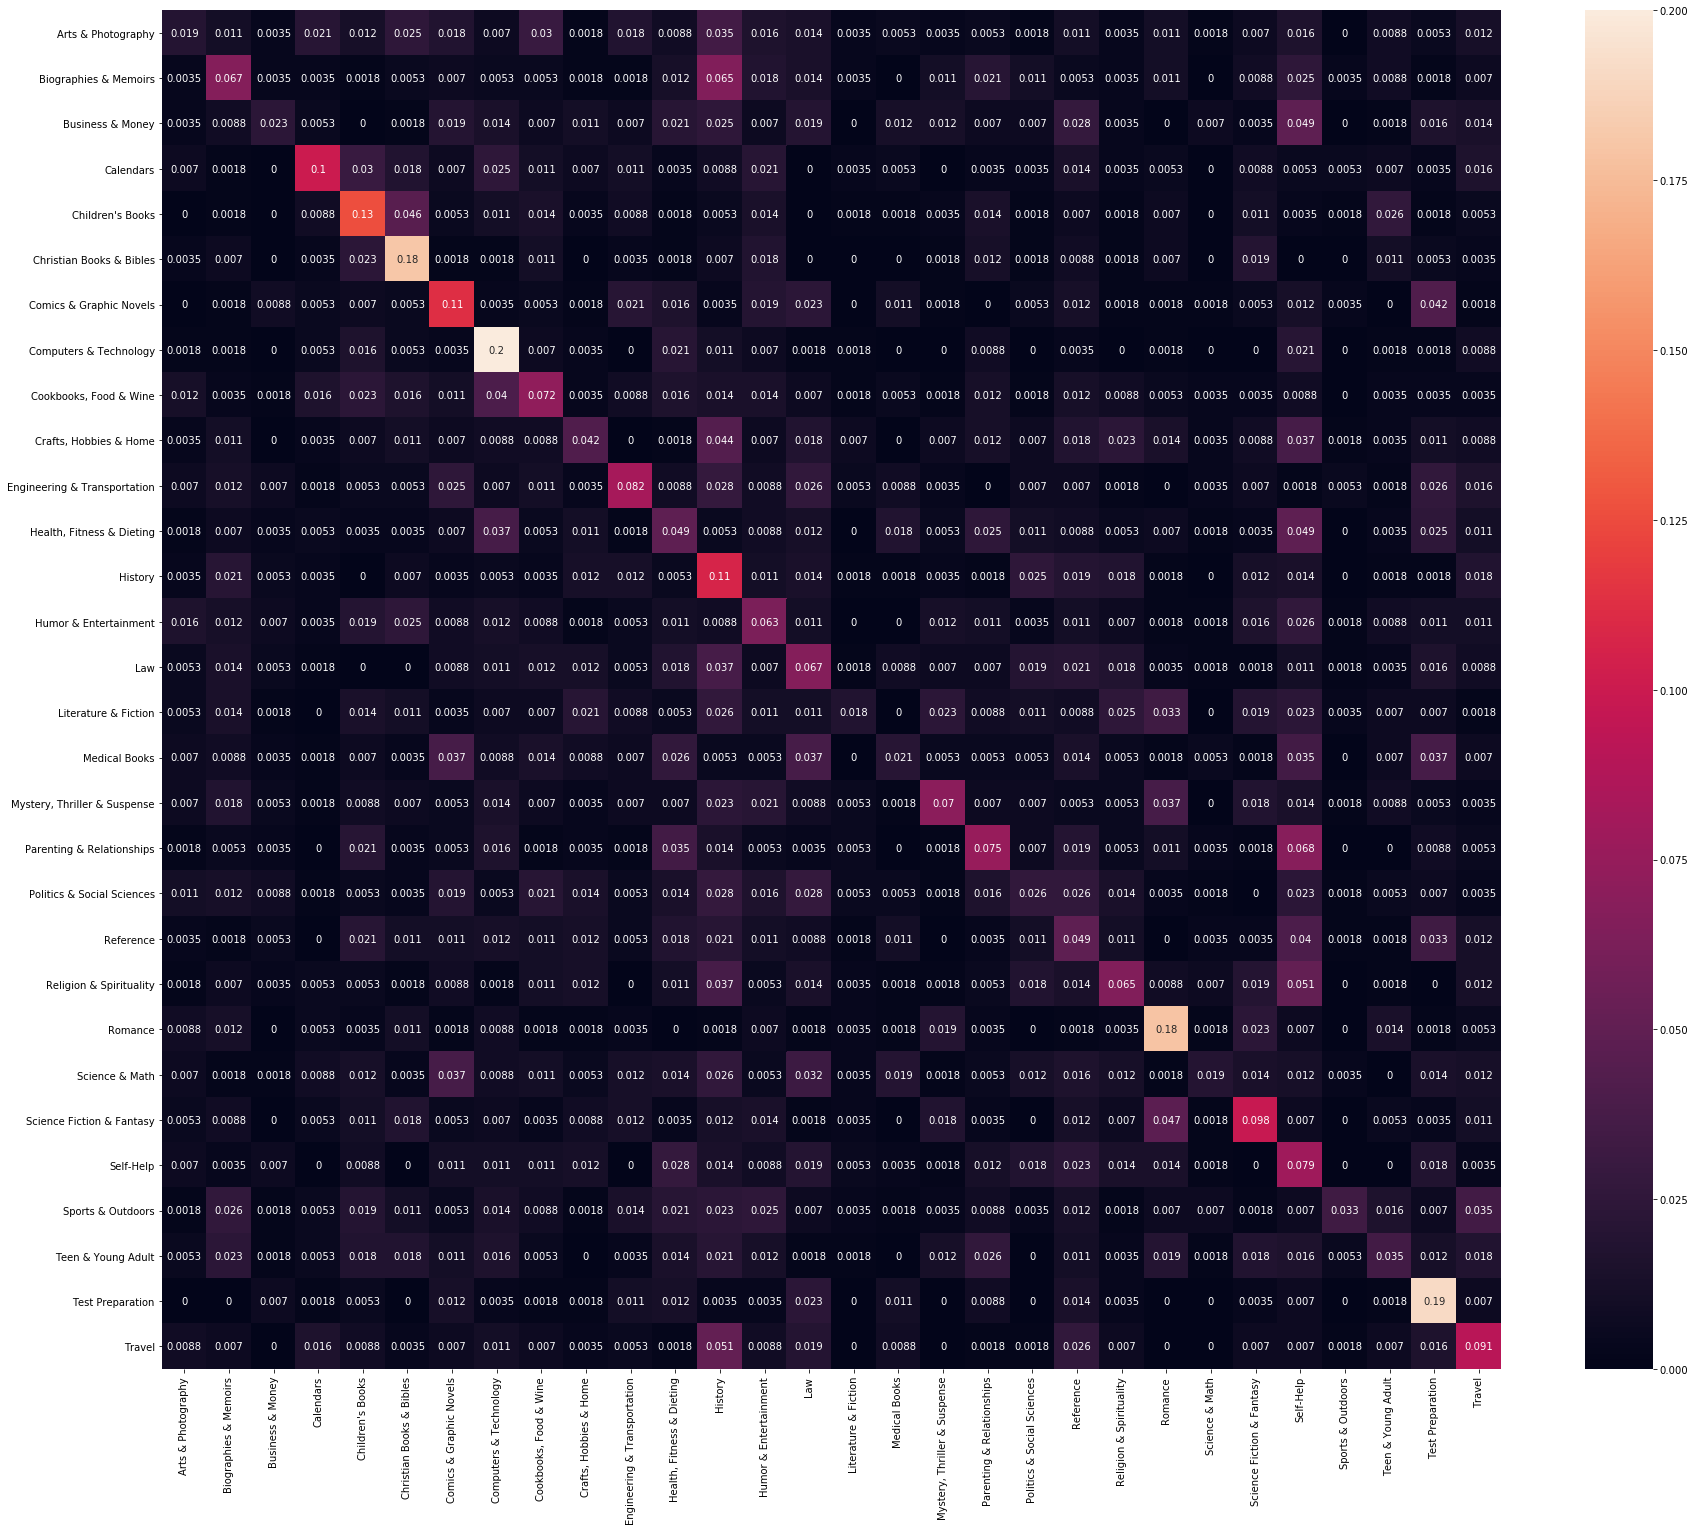

In [18]:
 test_model('model_1_202')